### Imports et initialisations

In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import random
import re
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import clustertools
from clustertools import *
#import torch

In [13]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_Std_clusters/som_400/"
#clean_dataset_file = "clusters/1M_Std_clusters/som_400/som_400_cluster_349_raw_msg.txt"
raw_dataset_file = "clusters/1M_Std_clusters/som_400/som_400_cluster_349_raw_msg.txt"

##### Récupération des tweets

In [24]:
#with open(clean_dataset_file, "r") as file:
#    lines = file.readlines()
    
#global_clean_sample = [line.split() for line in lines]
#clean_sample = [line[:-1] for line in lines if line[-1] == '\n']

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()
    
clean_dataset = [line.split() for line in raw_sample]

### Encodage à l'aide d'un transformer pré entraîné

On charge le modèle depuis le disque

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("models/model_multilangue")

In [6]:
%%time
encoded_dataset = model.encode(raw_dataset)

CPU times: user 5.11 s, sys: 1.48 s, total: 6.59 s
Wall time: 23.6 s


In [76]:
#clean_sample

### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [9]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(encoded_dataset)

CPU times: user 324 ms, sys: 967 ms, total: 1.29 s
Wall time: 247 ms


In [10]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.markersize"] = 3

In [25]:


init_globals(clean_dataset, raw_dataset, two_dim_dataset, cluster_dir)

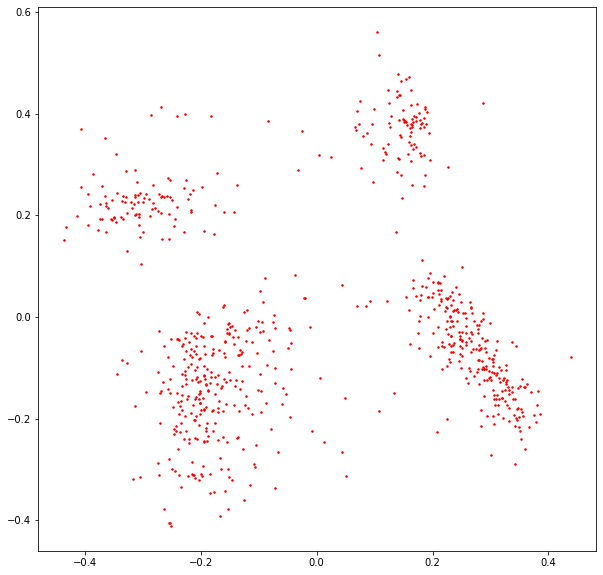

In [12]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### Kmeans

In [16]:
n_clust = 4

In [17]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(encoded_dataset)

CPU times: user 6.01 s, sys: 3.75 s, total: 9.75 s
Wall time: 1.32 s


In [19]:
km_pred = kmeans.predict(encoded_dataset)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
#km_centers = c = [[r[0] for r in w2v.similar_by_vector(center)] for center in km_model.cluster_centers_]

In [54]:
res = build_res_dict(km_pred)

In [35]:
wlists, mlists, cmlists, e2dmlists, mfw, hkw, clust_n_msg = parse(km_pred)

In [36]:
print_clusters_info(clust_n_msg, mfw, hkw, [])

In [50]:
for m in mfw.values(): print(m)

['MÈRE', 'mer', 'DE', 'LA', 'salope', 'c', 'pour', 'oh', 'mais', 'du', 'Mais', 'suis', 'On', '#SPACEAFROOO', 'PUTE', 'Ah', 'lui', 'ca', 'bz', 'me']
['mer', 'MÈRE', 'tu', 'lui', 'mais', 'C’est', 'enculé', 'Les', 'va', 'Oh', 'SA', 'bon', 'sale', 'plus', 'trop', 'du', 'elle', 'tout', "c'est", 'c']
['sale', 'Ma', 'te', 'dit', 'me', 'elle', 'trop', 'pour', 'va', 'tu', '«', 'niquez', 'j’ai', 'avec', '»', 'mais', 'Ta', 'vie', 'Oh', 'Le']
['plus', 'mon', 'niquez', 'Ta', 'Ma', 'si', 'dans', 'aussi', 'dit', 'lui', 'leur', 'ce', 'Les', 'bz', 'ton', 'père', 'Oh', 'Mais', 'fait', 'Vos']


In [52]:
save_clusters_info(clust_n_msg, mfw, hkw, "km_4_transformer", centers=[])

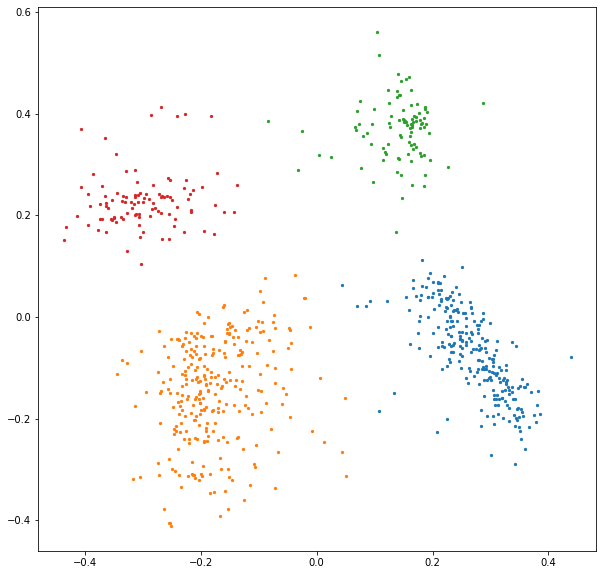

In [55]:
plot_results(res)

### SOM

In [56]:
from sklearn_som.som import SOM

In [58]:
som_normalized_dataset = np.array([vect / np.linalg.norm(vect) if np.linalg.norm(vect) != 0 else vect for vect in encoded_dataset])

In [60]:
%%time

som = SOM(m=2, n=2, dim=512)
som.fit(som_normalized_dataset)

CPU times: user 467 ms, sys: 0 ns, total: 467 ms
Wall time: 469 ms


In [61]:
%%time

som_pred = som.predict(som_normalized_dataset)

CPU times: user 35.1 ms, sys: 4.81 ms, total: 39.9 ms
Wall time: 35.2 ms


In [31]:
som_centers = [[r[0] for r in w2v.similar_by_vector(center)] for center in som.weights]

Cluster 0 : 95 messages
33 messages contiennent un mot-clé haineux (soit 34.74%)
Les 20 mots les plus fréquents : MÈRE mer DE LA salope c pour oh mais du Mais suis On #SPACEAFROOO PUTE Ah lui ca bz me 


Cluster 1 : 248 messages
83 messages contiennent un mot-clé haineux (soit 33.47%)
Les 20 mots les plus fréquents : mer MÈRE lui tu C’est enculé Les mais Oh SA va bon sale plus trop du elle tout c'est c 


Cluster 2 : 102 messages
12 messages contiennent un mot-clé haineux (soit 11.76%)
Les 20 mots les plus fréquents : plus mon niquez Ta Ma si dans aussi dit lui leur ce Les bz ton père Oh Mais fait Vos 


Cluster 3 : 283 messages
45 messages contiennent un mot-clé haineux (soit 15.90%)
Les 20 mots les plus fréquents : sale Ma te va tu « dit me elle trop pour » niquez j’ai mais avec Ta vie Oh Le 




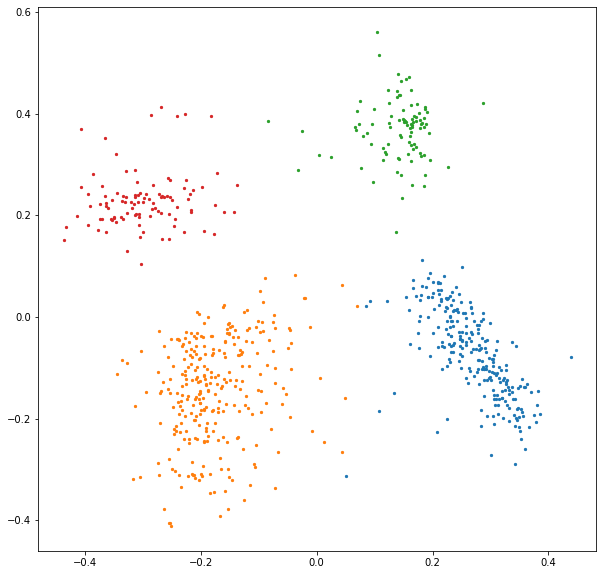

In [63]:
parse_no_save(som_pred, #"som", som_centers)
              [])

In [30]:
import importlib
import clustertools

In [51]:
importlib.reload(clustertools)
from clustertools import *